# Some examples of image manipulation for evaluating OCR

First, some imports.

In [1]:
import cv2                      # Computer Vision
import numpy as np              # Vector math
import matplotlib.pyplot as plt # Plotting
%matplotlib inline

Let's generate an image with text.

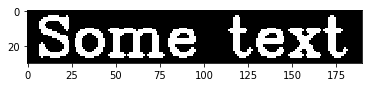

In [2]:
img = np.asarray(cv2.putText(np.zeros((30, 190)), "Some text", (5, 25), cv2.FONT_HERSHEY_COMPLEX,
                             1.0, (255, 255, 255), 2, cv2.LINE_AA)
                 , dtype=np.uint8)

plt.imshow(img, cmap='gray');

In [3]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

A connected component is a patch of similarly coloured pixels.

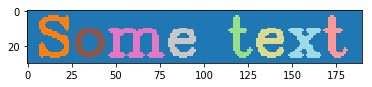

In [4]:
_, cc = cv2.connectedComponents(img, connectivity=4)
plt.imshow(cc, cmap='tab20')

Let's try some salt and papper noise. This is the type of noise you get using 

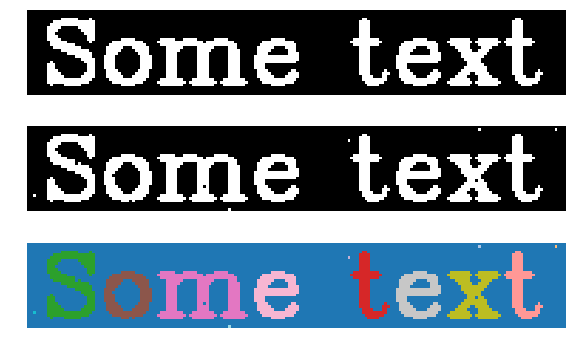

In [5]:
def salt_and_papper_noise(image, n_noise=10):
    img_sp = image.copy()
    for i in range(n_noise):
        a = np.random.randint(img_sp.shape[0])
        b = np.random.randint(img_sp.shape[1])
        if img_sp[a, b] == 0:
            img_sp[a, b] = 255
        else:
            img_sp[a, b] = 0
    return img_sp

img_sp = salt_and_papper_noise(img, 10)

plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(img_sp, cmap='gray')
plt.axis('off');
plt.subplot(3, 1, 3)
_, cc = cv2.connectedComponents(img_sp, connectivity=4)
plt.imshow(cc, cmap='tab20')
plt.axis('off');
plt.tight_layout()
plt.show()

Salt and pepper noise can, at least to some extent, be removed using a median filter.

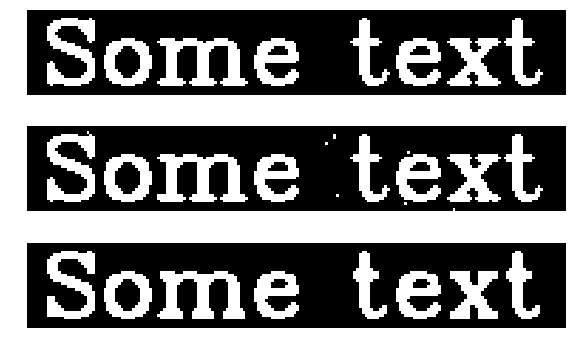

In [6]:
# Median filtering
img_sp = salt_and_papper_noise(img, 10)
img_median = cv2.medianBlur(img_sp, 3)

plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(img_sp, cmap='gray')
plt.axis('off');
plt.subplot(3, 1, 3)
plt.imshow(img_median, cmap='gray')
plt.axis('off');
plt.tight_layout()
plt.show()

## Gaussian noise

Another kind of common noise is Gaussian noise. This is the type of noise that makes the image "grainy".

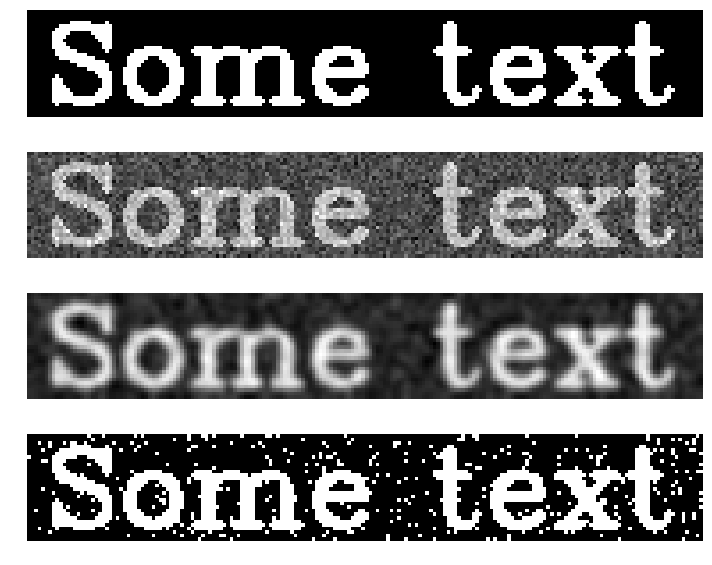

In [9]:
# When working with Gaussian noise, we need some space between the used colours and the data type limits.
img[img==0] = 100
img[img==255] = 200

# Add some Gaussian noise
sigma = 20
img_noise = img + np.random.normal(0, sigma, size=img.shape)

# Convert back to 8bit image
img_noise[img_noise<0] = 0
img_noise[img_noise>255] = 255
img_noise = np.asarray(img_noise, dtype=np.uint8)

# Blur to average out the noise
img_blur = cv2.GaussianBlur(img_noise, (5, 5), 0)

# Threshold the image to separate foreground and background
_, img_thresholded = cv2.threshold(img_noise, 127, 255, cv2.THRESH_BINARY)


plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(4, 1, 2)
plt.imshow(img_noise, cmap='gray')
plt.axis('off');
plt.subplot(4, 1, 3)
plt.imshow(img_blur, cmap='gray')
plt.axis('off');
plt.subplot(4, 1, 4)
plt.imshow(img_thresholded, cmap='gray')
plt.axis('off');
plt.tight_layout()
plt.show()

Now, let's try this while varying the noise intensity.

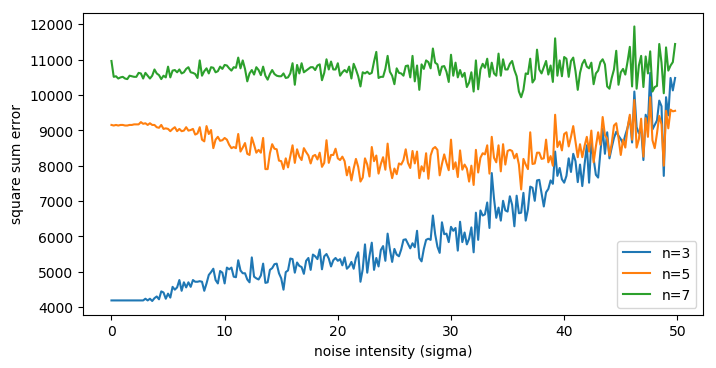

In [8]:
def distort(image, sigma):
    """Add Gaussian noise"""
    img_noise = image + np.random.normal(0, sigma, size=image.shape)
    img_noise[img_noise<0] = 0
    img_noise[img_noise>255] = 255
    return np.asarray(img_noise, dtype=np.uint8)

def blur(image, n):
    """Gaussian blur"""
    return cv2.GaussianBlur(image, (n, n), 0)

def binarize(image):
    """Separate foreground from background"""
    _, img_thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    img_thresholded[img_thresholded==0] = 100
    img_thresholded[img_thresholded==255] = 200
    return img_thresholded

sigmas = np.arange(0, 50, 0.2)
filter3 = list()
filter5 = list()
filter7 = list()
for sigma in sigmas:
    I = distort(img, sigma)
    filter3.append(np.sum((img - binarize(blur(I, 3)))**2))
    filter5.append(np.sum((img - binarize(blur(I, 5)))**2))
    filter7.append(np.sum((img - binarize(blur(I, 7)))**2))

plt.figure(figsize=(8, 4), dpi=100)
plt.plot(sigmas, filter3, label="n=3")
plt.plot(sigmas, filter5, label="n=5")
plt.plot(sigmas, filter7, label="n=7")
plt.legend(loc='lower right')
plt.ylabel("square sum error")
plt.xlabel("noise intensity (sigma)");